In [ ]:
import pandas as pd
import numpy as np

X_test = pd.read_csv("./X_test.csv")
df_y_test = pd.read_csv("./y_test.csv")
y_test = df_y_test.squeeze()
X_train = pd.read_csv("./X_train.csv")
df_y_train = pd.read_csv("./y_train.csv")
y_train = df_y_train.squeeze()

In [11]:
from sklearn import svm, metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform
import numpy as np
import pandas as pd

# --- Step 3: Identify numerical and categorical features ---
column_dtypes_train_filtered = X_train.dtypes
numerical_features_train_filtered = column_dtypes_train_filtered[
    column_dtypes_train_filtered.apply(lambda x: np.issubdtype(x, np.number))
].index.tolist()

categorical_features_train_filtered = X_train.select_dtypes(include='object').columns.tolist()

# --- Step 4: Preprocessing Pipeline ---
preprocessor_svm = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features_train_filtered),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features_train_filtered)
    ],
    remainder='drop'
)

# --- Step 5: Define Model and Pipeline ---
svm_clf = svm.SVC(random_state=1234, class_weight='balanced')

pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor_svm),
    ('svm', svm_clf)
])

# --- Step 6: Expanded Hyperparameter Search Space ---
param_distributions = {
    'svm__C': loguniform(1e-3, 1e3),
    'svm__gamma': loguniform(1e-4, 1e0),
    'svm__kernel': ['rbf', 'poly', 'sigmoid']
}

# --- Step 7: Cross-validation Strategy ---
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

# --- Step 8: RandomizedSearchCV for Efficiency ---
random_search = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_distributions,
    n_iter=30,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    random_state=1234,
    verbose=2
)

# --- Align X and y before fitting ---
X_train_aligned, y_train_aligned = X_train.align(y_train, join='inner', axis=0)
print(f"Aligned training shapes: X={X_train.shape}, y={y_train_aligned.shape}")

print("\nStarting RandomizedSearchCV for SVM hyperparameter tuning...")
random_search.fit(X_train_aligned, y_train_aligned)
print("RandomizedSearchCV finished.")


# --- Step 9: Retrieve and Evaluate Best Model ---
best_params_svm = random_search.best_params_
best_score_svm = random_search.best_score_
best_model_svm = random_search.best_estimator_

print("\nBest SVM Hyperparameters:", best_params_svm)
print("Best cross-validation accuracy:", best_score_svm)

Aligned training shapes: X=(1664, 72), y=(1664,)

Starting RandomizedSearchCV for SVM hyperparameter tuning...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END svm__C=4.7062107124885095, svm__gamma=0.12174178788224209, svm__kernel=poly; total time=   0.2s
[CV] END svm__C=4.7062107124885095, svm__gamma=0.12174178788224209, svm__kernel=poly; total time=   0.2s
[CV] END svm__C=0.014096675490461206, svm__gamma=0.03079180048983015, svm__kernel=rbf; total time=   0.2s
[CV] END svm__C=0.043207151101399784, svm__gamma=0.0012760186458599522, svm__kernel=sigmoid; total time=   0.2s
[CV] END svm__C=0.043207151101399784, svm__gamma=0.0012760186458599522, svm__kernel=sigmoid; total time=   0.2s
[CV] END svm__C=0.014096675490461206, svm__gamma=0.03079180048983015, svm__kernel=rbf; total time=   0.3s
[CV] END svm__C=0.014096675490461206, svm__gamma=0.03079180048983015, svm__kernel=rbf; total time=   0.3s
[CV] END svm__C=4.7062107124885095, svm__gamma=0.12174178788224209, svm__ker

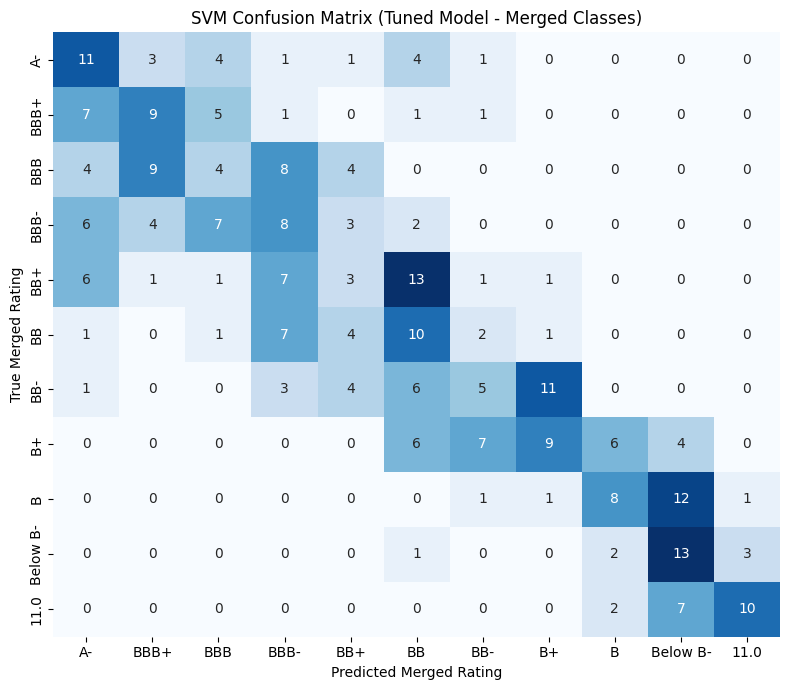


Tuned SVM Accuracy on Test Set: 0.3103448275862069

Classification Report (Tuned SVM Model - Merged Classes):
              precision    recall  f1-score   support

          A-       0.31      0.44      0.36        25
        BBB+       0.35      0.38      0.36        24
         BBB       0.18      0.14      0.16        29
        BBB-       0.23      0.27      0.25        30
         BB+       0.16      0.09      0.12        33
          BB       0.23      0.38      0.29        26
         BB-       0.28      0.17      0.21        30
          B+       0.39      0.28      0.33        32
           B       0.44      0.35      0.39        23
    Below B-       0.36      0.68      0.47        19
        11.0       0.71      0.53      0.61        19

    accuracy                           0.31       290
   macro avg       0.33      0.34      0.32       290
weighted avg       0.31      0.31      0.30       290



In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred_SVM_tuned = best_model_svm.predict(X_test)
Accuracy_SVM_tuned = metrics.accuracy_score(y_test, y_pred_SVM_tuned)

merged_rating_order_str = ['Above A', 'A-', 'BBB+', 'BBB',
                         'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'Below B-']
merged_rating_map_num = {rating: i for i, rating in enumerate(merged_rating_order_str)}
inverted_merged_rating_map_str = {v: k for k, v in merged_rating_map_num.items()}

cm = confusion_matrix(y_test, y_pred_SVM_tuned, labels=best_model_svm.classes_)

cm_df = pd.DataFrame(cm, index=best_model_svm.classes_, columns=best_model_svm.classes_)

string_labels = [inverted_merged_rating_map_str.get(c, str(c)) for c in best_model_svm.classes_]

cm_df.index = string_labels
cm_df.columns = string_labels


plt.figure(figsize=(8, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix (Tuned Model - Merged Classes)')
plt.xlabel('Predicted Merged Rating')
plt.ylabel('True Merged Rating')
plt.tight_layout()
plt.show()

# --- Classification Report ---
from sklearn.metrics import classification_report
print("\nTuned SVM Accuracy on Test Set:", Accuracy_SVM_tuned)
print("\nClassification Report (Tuned SVM Model - Merged Classes):")
print(classification_report(y_test, y_pred_SVM_tuned, target_names=string_labels, zero_division=0))

In [6]:
# Linear SVM (better for high correlation features)
from sklearn import svm

svm_linear = svm.SVC(kernel='linear', random_state=1234, class_weight='balanced')

pipeline_svm_linear = Pipeline(steps=[
    ('preprocessor', preprocessor_svm),
    ('svm', svm_linear)
])

param_distributions_linear = {
    'svm__C': loguniform(1e-2, 1e2),
}

random_search_linear = RandomizedSearchCV(
    pipeline_svm_linear,
    param_distributions=param_distributions_linear,
    n_iter=20,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    random_state=1234,
    verbose=2
)

print("Training Linear SVM...")
random_search_linear.fit(X_train_aligned, y_train_aligned)

y_pred_linear = random_search_linear.best_estimator_.predict(X_test)
accuracy_linear = metrics.accuracy_score(y_test, y_pred_linear)

print("\nLinear SVM Results:")
print("Best parameters:", random_search_linear.best_params_)
print("Test accuracy:", accuracy_linear)

Training Linear SVM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .........................svm__C=0.05835496346821344; total time=   0.1s
[CV] END .........................svm__C=0.05835496346821344; total time=   0.1s
[CV] END .........................svm__C=0.05835496346821344; total time=   0.1s
[CV] END ..........................svm__C=0.5635221042987834; total time=   0.2s
[CV] END ..........................svm__C=0.5635221042987834; total time=   0.2s
[CV] END ..........................svm__C=0.5635221042987834; total time=   0.2s
[CV] END ..........................svm__C=3.0791800489830163; total time=   0.4s
[CV] END ..........................svm__C=3.0791800489830163; total time=   0.4s
[CV] END ..........................svm__C=3.0791800489830163; total time=   0.5s
[CV] END .........................svm__C=0.12313185468743894; total time=   0.1s
[CV] END .........................svm__C=0.12313185468743894; total time=   0.1s
[CV] END ................

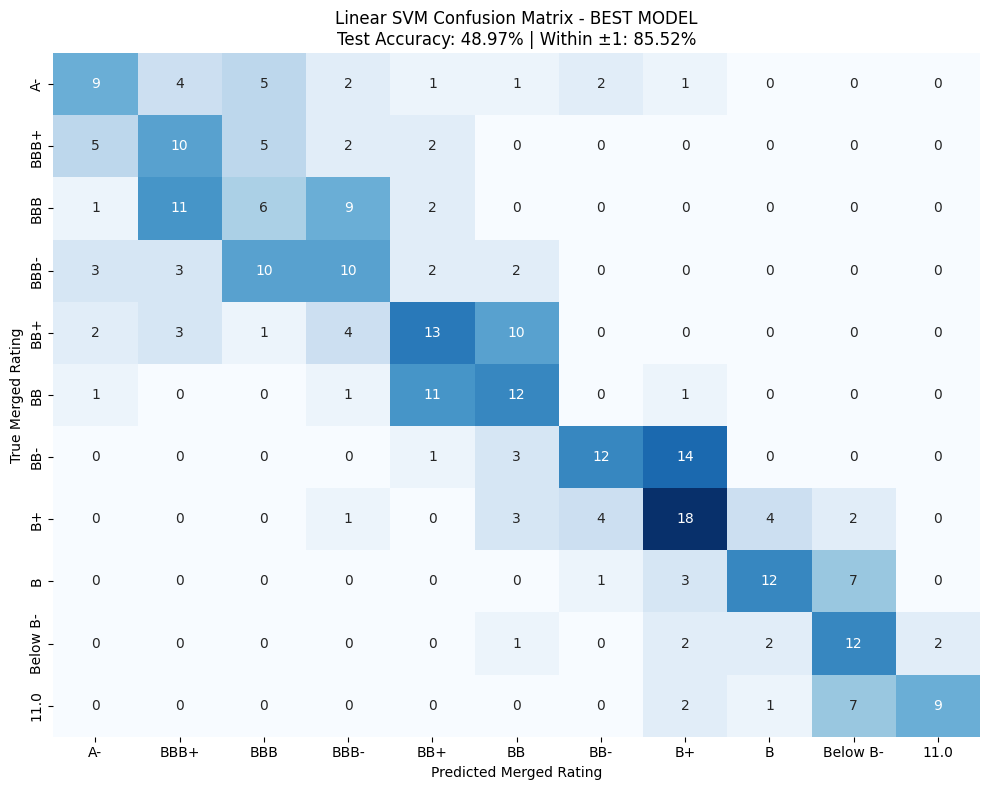


BEST MODEL - Linear SVM Classification Report
              precision    recall  f1-score   support

          A-       0.43      0.36      0.39        25
        BBB+       0.32      0.42      0.36        24
         BBB       0.22      0.21      0.21        29
        BBB-       0.34      0.33      0.34        30
         BB+       0.41      0.39      0.40        33
          BB       0.38      0.46      0.41        26
         BB-       0.63      0.40      0.49        30
          B+       0.44      0.56      0.49        32
           B       0.63      0.52      0.57        23
    Below B-       0.43      0.63      0.51        19
        11.0       0.82      0.47      0.60        19

    accuracy                           0.42       290
   macro avg       0.46      0.43      0.44       290
weighted avg       0.45      0.42      0.43       290



In [8]:
# Visualize the best model (Linear SVM) performance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_linear = confusion_matrix(y_test, y_pred_linear, labels=best_model_svm.classes_)

cm_df_linear = pd.DataFrame(cm_linear, index=best_model_svm.classes_, columns=best_model_svm.classes_)

string_labels = [inverted_merged_rating_map_str.get(c, str(c)) for c in best_model_svm.classes_]

cm_df_linear.index = string_labels
cm_df_linear.columns = string_labels

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_linear, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Linear SVM Confusion Matrix - BEST MODEL\nTest Accuracy: 48.97% | Within ±1: 85.52%')
plt.xlabel('Predicted Merged Rating')
plt.ylabel('True Merged Rating')
plt.tight_layout()
plt.show()

# Classification Report
from sklearn.metrics import classification_report
print("\n" + "="*80)
print("BEST MODEL - Linear SVM Classification Report")
print("="*80)
print(classification_report(y_test, y_pred_linear, target_names=string_labels, zero_division=0))